In [1]:
import numpy as np 
import pandas as pd

In [2]:
def normaliseMatrix(matrix): # returns a normalised decision matrix
    #sanitize input
    if type(matrix) != np.ndarray:matrix = np.array(matrix) 

    dim = matrix.shape # get dimension of the matrix
    normalMatrix = np.empty(dim) # an empty matrix for the normalised values
    n,x = dim

    for i in range(n): # row (RAT)
        for j in range(x): # column (criteria)
            col = matrix[:,j] # get column j
            m = matrix[i,j] # get the value of the matrix at (row i,column j)
            normalMatrix[i,j] = m/np.sqrt( np.sum( np.square(col) ) )
    
    return normalMatrix

def normaliseWeight(weight): # returns normalised weights
    w = weight/np.sum(weight)
    return w

def H(normalMatrix,normalWeight): # returns weighted normalised decision matrix
    H = normalMatrix * normalWeight
    return H 

In [3]:
def solution(h,isBenefitCriteria): # return two arrays one for ideal solution the other for negative ideal
    
    # isBenefitCriteria represent a vector with boolean value where each boolean corresponds
    # with the criterion "benefit status", true means is a benefit criteria and false means is a negative 
    
    if len(isBenefitCriteria)!=h.shape[1]:
        return 0

    x = len(isBenefitCriteria)
    
    aBest = np.zeros(x) 
    aWorst = np.zeros(x)

    for j in range(x):
        col = h[:,j]
        aBest[j] = np.max(col) if isBenefitCriteria[j] else np.min(col)
        aWorst[j] = np.min(col) if isBenefitCriteria[j] else np.max(col)

    # [cost, latency, data rate, coverage area, energy consumption]
    return aBest, aWorst 

In [4]:
def distance(h,solution): # returns the distance
    n = h.shape[0] # get the number of RATs
    d = np.zeros(n) # the ideal(positive or negative) distance for each RAT
    
    for i in range(n):
        row = h[i,:] # get row i
        d[i]=np.sqrt(np.sum(np.square(row-solution)))
    
    return d # [3G 4G 5G] 

def closenessCoeff(posDistance,negDistance): # returns the closeness coefficient 
    return negDistance/(posDistance+negDistance)

In [5]:
def TOPSIS(matrix, weight, isBenefitCriteria): 
    # return closeness cofficient for each RAT in an array [3G,4G,5G]
    n,x = matrix.shape
    closeCoeff = np.zeros(n)

    # normalised matrix and weight
    normalMatrix = normaliseMatrix(matrix)
    normalWeight = normaliseWeight(weight)

    # weighted normalised decision matrix
    normalWeightMatrix = H(normalMatrix,normalWeight)

    # positive ideal solution, negative ideal solution
    posIdealSol, negIdealSol = solution(normalWeightMatrix,isBenefitCriteria) 
    
    posD = distance(normalWeightMatrix,posIdealSol) # distance to negative ideal solution
    negD = distance(normalWeightMatrix,negIdealSol) # distance to positive ideal solution

    for i in range(n):
        closeCoeff[i]=closenessCoeff(posD[i],negD[i])
    
    return closeCoeff # [3G, 4G, 5G]

In [6]:
# Test Example
RATs = ["3G","4G","5G"]
m = np.array([[5,50,5,3,0.1],[8,20,100,5,0.15],[9,1,1000,1,0.5]]) # given matrix
w = np.array((8,2,5,1,6)) # given weights
isBenefitCriteria = np.array((False,False,True,True,False)) # is criterion a benefit?

rank = TOPSIS(m,w,isBenefitCriteria)
 
df = pd.DataFrame(rank.reshape(1,-1), columns=RATs, index=["f"])

df

,3G,4G,5G
f,0.49356,0.462162,0.504323


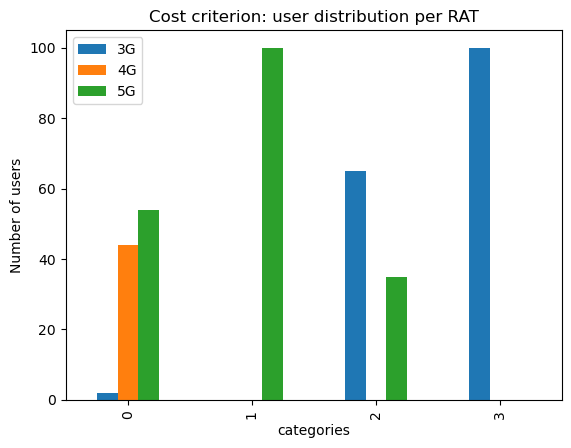

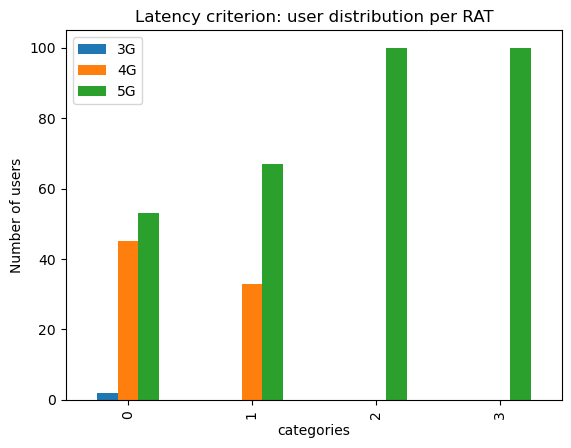

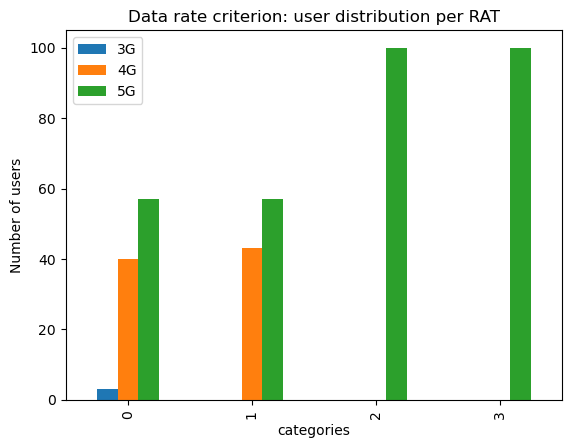

In [7]:
#=====================Criterion_Effects======================#
#[cost, latency, data rate, coverage area, energy consumption]

criteria = ["Cost", "Latency", "Data rate", "Coverage area", "Energy consumption"]
selectCriterion = [1,1,1,0,0] # selected criteria

# for each selected criterion 
# simulate category 0: random weight assignment 
# simulate category 1: selected criterion weight is is between 0-2, the rest the weight = 1
# simulate category 2: selected criterion weight is is between 3-5, the rest the weight = 1
# simulate category 3: selected criterion weight is is between 6-8, the rest the weight = 1
# plot category 0-3 on the same plot

for i in range(m.shape[1]):
    
    if not selectCriterion[i]: continue # skip criterion not selected

    categories = np.empty((4,3)) # 4 categories 3 RATs
    users = 100 # number of users 
    RATfreq = np.zeros(m.shape[0]) # RAT frequency = how many times is a specific RAT chosen 
    # category 0
    for r in range(users):
        
        w = np.random.randint(0,9,5)

        rank = TOPSIS(m,w,isBenefitCriteria) 
        maxf = rank==np.max(rank) # creates a boolean array where true represent the position of max f (selected RAT)
        
        RATfreq += maxf*1 # adds 1 to selected RAT position 1*true = 1, 1*false = 0 
    categories[0]=RATfreq
   
    # category 1
    RATfreq = np.zeros(m.shape[0])
    w = np.ones(5)
    for r in range(users):
        w[i] = np.random.randint(0,3)

        rank = TOPSIS(m,w,isBenefitCriteria) 
        maxf = rank==np.max(rank) # creates a boolean array where true represent the position of max f (selected RAT)
        
        RATfreq += maxf*1 # adds 1 to selected RAT position 1*true = 1, 1*false = 0 
    categories[1]=RATfreq
    RATfreq = np.zeros(m.shape[0])
    
    # category 2
    for r in range(users):
        w[i] = np.random.randint(3,6)

        rank = TOPSIS(m,w,isBenefitCriteria) 
        maxf = rank==np.max(rank) # creates a boolean array where true represent the position of max f (selected RAT)
        
        RATfreq += maxf*1 # adds 1 to selected RAT position 1*true = 1, 1*false = 0 
    categories[2]=RATfreq
    RATfreq = np.zeros(m.shape[0])
    
    # category 3
    for r in range(users):
        w[i] = np.random.randint(6,9)
        rank = TOPSIS(m,w,isBenefitCriteria) 
        maxf = rank==np.max(rank) # creates a boolean array where true represent the position of max f (selected RAT)
        
        RATfreq += maxf*1 # adds 1 to selected RAT position 1*true = 1, 1*false = 0 
    categories[3]=RATfreq

    
    df = pd.DataFrame(categories,columns=RATs)
    t = criteria[i]+" criterion: user distribution per RAT"
    
    df.plot(kind='bar', title=t, ylabel="Number of users", xlabel="categories")